<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.2
tiktoken version: 0.5.1
torch version: 2.2.2
tqdm version: 4.66.1
tensorflow version: 2.15.0


## 7.1 Introduction to instruction finetuning

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this chapter, we teach the LLM to better follow instructions

[insert figure]

- An optional step after instruction finetuning is preference tuning, which refines the response style of an LLM; readers interested in preference tuning can find example code in the bonus materials: [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo)

- The topics covered in this chapter are summarized in the figure below

[insert figure]

## 7.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this chapter

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form:

In [3]:
print("Example entry:\n\n", data[50])

Example entry:

 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [4]:
print("Another example entry:\n\n", data[999])

Another example entry:

 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

[insert figure]

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Below we format the input that we will pass as input to the LLM

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set

In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)   # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Creating data loaders for an instruction dataset

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [11]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(
                    full_text, allowed_special={"<|endoftext|>"}
                )
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [12]:
# Explain index masking

targets = torch.tensor([0, 1])
inputs = torch.tensor(
    [[-1., 1.],
     [-0.5, 1.5]]
)

torch.nn.functional.cross_entropy(inputs, targets)

tensor(1.1269)

In [13]:
targets = torch.tensor([0, 1, 1])
inputs = torch.tensor(
    [[-1., 1.],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
torch.nn.functional.cross_entropy(inputs, targets)

tensor(0.7936)

In [14]:
targets = torch.tensor([0, 1, -100])
inputs = torch.tensor(
    [[-1., 1.],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
torch.nn.functional.cross_entropy(inputs, targets)

tensor(1.1269)

In [15]:
def custom_collate_fn(
    batch, 
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None, 
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []
    for item in batch:
        # Pad sequences to max_length
        padded = item + [pad_token_id] * (batch_max_length - len(item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [16]:
inputs_1 = [0, 1, 2, 3, 4, 50256, 50256]
inputs_2 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2
)

custom_collate_fn(batch)

(tensor([[    0,     1,     2,     3,     4, 50256],
         [    7,     8,     9, 50256, 50256, 50256]]),
 tensor([[    1,     2,     3,     4, 50256,  -100],
         [    8,     9, 50256,  -100,  -100,  -100]]))

In [17]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(custom_collate_fn, device=device)

Device: cpu


In [18]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True
)

In [19]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False
)

In [20]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 67]) torch.

In [21]:
for i in x[0]:
    print(i.item(), end=", ")

21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 30003, 6525, 262, 6827, 1262, 257, 985, 576, 13, 198, 198, 21017, 23412, 25, 198, 464, 5156, 318, 845, 13779, 13, 198, 198, 21017, 18261, 25, 198, 464, 5156, 318, 355, 13779, 355, 257, 4936, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [22]:
for i in y[0]:
    print(i.item(), end=", ")

318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 30003, 6525, 262, 6827, 1262, 257, 985, 576, 13, 198, 198, 21017, 23412, 25, 198, 464, 5156, 318, 845, 13779, 13, 198, 198, 21017, 18261, 25, 198, 464, 5156, 318, 355, 13779, 355, 257, 4936, 13, 50256, -100, -100, -100, -100, -100, -100, -100, -100, 

## 7.4 Loading a pretrained LLM

In [23]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [24]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(format_input(val_data[0]), tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
)

print(token_ids_to_text(token_ids, tokenizer))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.5 Finetuning the LLM on instruction data

In [25]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [26]:
model.to(device)

torch.manual_seed(123)  # For reproducibility due to the shuffling in the data loader

with torch.no_grad():  # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8234103202819822
Validation loss: 3.7612109184265137


- Runtimes:

<div style="text-align: left;">
    
| Model              | Platform              | Runtime        |
|--------------------|-----------------------|----------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 23.67 minutes  |
| gpt2-medium (355M) | GPU (A100)            | 1.29 minutes   |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 8.61           |
| gpt2-small (124M)  | GPU (A100)            | 0.59 minutes   |

</div>

- Remainder of the notebook was run on M3 MacBook Air with the `"gpt2-medium (355M)"` model

In [27]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 3

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.636, Val loss 2.627
Ep 1 (Step 000005): Train loss 1.173, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.873, Val loss 0.947
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.907
Ep 1 (Step 000020): Train loss 0.777, Val loss 0.882
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.860
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.838
Ep 1 (Step 000035): Train loss 0.715, Val loss 0.810
Ep 1 (Step 000040): Train loss 0.673, Val loss 0.807
Ep 1 (Step 000045): Train loss 0.634, Val loss 0.791
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.784
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.721, Val loss 0.745
Ep 1 (Step 000065): Train loss 0.654, Val loss 0.736
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.730
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.606, Val loss 0.726
Ep 1 (Step 000085): Train loss 0.511, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

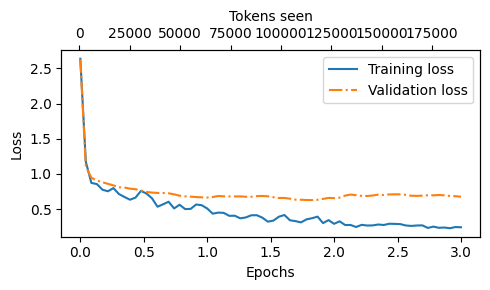

In [28]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.6 Extracting and saving responses

In [29]:
def extract_response(response):
    return response[response.find("\n### Response")+len("\n### Response:")+1:]

In [30]:
torch.manual_seed(123)

for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    response = token_ids_to_text(token_ids, tokenizer)
    response_text = extract_response(response)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and 

In [31]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    response = token_ids_to_text(token_ids, tokenizer)
    response_text = extract_response(response)

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|█████████████████████████████████████████| 110/110 [06:24<00:00,  3.50s/it]


In [32]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

In [33]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


## 7.7 Evaluating the finetuned LLM

In [34]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print(check_if_running("ollama"))

True


In [35]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "seed": 123,        # for deterministic responses
        "temperature": 0,   # for deterministic responses
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tallgrass, shortgrass, and bunchgrasses.
2. Leaves: They enjoy munching on leaves from trees and shrubs, such as oak, maple, and willow.
3. Fruits: Llamas enjoy fruits like apples, berries, and melons.
4. Hay: A good quality hay, such as timothy or alfalfa, is often provided as a staple in their diet.
5. Grains: Whole grains like oats, barley, and corn can be offered as treats or as part of their regular feed.
6. Supplements: In some cases, llama owners may choose to add commercial supplements or mineral blocks to ensure the animal is getting all the necessary nutrients.

It's worth noting that llamas are ruminants, meaning they have a four-chambered stomach designed specifically for digesting plant-based foods. Their digestive system is well-suited to break down and extract nutrients from cell

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 Gb of RAM

In [36]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> A fun task!

To score this response, I'll consider the following factors:

1. Grammar and syntax: The sentence is grammatically correct.
2. Simile quality: A bullet is a relatively fast-moving object, making it a decent comparison for a fast car.
3. Originality: While not extremely original, the comparison to a bullet is a common simile used to describe speed.

Score: 85

Reasoning: The response is good but not outstanding. Using a bullet as a simile for speed is a classic and understandable choice. However, it's not particularly creative or surprising, which is why I wouldn't give it a perfect score of 100. Overall, the response effectively completes the instruction and conveys the idea that the car is fast.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud t

In [37]:
def generate_model_scores(json_data, json_key):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [00:46<00:00,  2.39it/s]

Number of scores: 110 of 110
Average score: 48.98



- For reference, the original
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B instruct model achieves a score of 82.65

## 7.8 Conclusions

## Summary